In [1]:
import torch
import torch.nn as nn 
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [3]:
latent_dim = 100

# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    # 하나의 블록(block) 정의
    def block(input_dim, output_dim, normalize=True):
      layers = [nn.Linear(input_dim, output_dim)]
      if normalize:
        # 배치 정규화(batch normalization) 수행(차원 동일)
        layers.append(nn.BatchNorm1d(output_dim, 0.8))
      layers.append(nn.LeakyReLU(0.2, inplace=True))
      return layers

    # 생성자 모델은 연속적인 여러 개의 블록을 가짐
    self.model = nn.Sequential(
      *block(latent_dim, 128, normalize=False),
      *block(128, 256),
      *block(256, 512),
      *block(512, 1024),
      nn.Linear(1024, 1 * 28 * 28),
      nn.Tanh()
    )

  def forward(self, z):
       #노이즈 벡터 z
      img = self.model(z)
      img = img.view(img.size(0), 1, 28, 28)
      return img

In [4]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
      nn.Linear(1 * 28 * 28, 512),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(256, 1),
      nn.Sigmoid(), # 확률값을 내보냄
      )

  # 이미지에 대한 판별 결과를 반환
  def forward(self, img):
    flattened = img.view(img.size(0), -1)
    output = self.model(flattened)

    return output

학습 데이터셋 불러오기
* 학습을 위해 MNIST 데이터셋을 불러옵니다.

In [5]:
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
# 생성자와 판별자 초기화
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 손실 함수
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

# 학습률 설정
lr = 0.0002

# 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [7]:
import time

n_epochs = 200 # 학습의 횟수(epoch) 설정
sample_interval = 2000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
  for i, (imgs, _) in enumerate(dataloader):

    # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
    real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
    fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0

    real_imgs = imgs.cuda()

    """ 생성자(generator)를 학습합니다. """
    optimizer_G.zero_grad()

    # 랜덤 노이즈(noise) 샘플링
    z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

    # 이미지 생성
    generated_imgs = generator(z)

    # 생성자(generator)의 손실(loss) 값 계산
    g_loss = adversarial_loss(discriminator(generated_imgs), real)

    # 생성자(generator) 업데이트
    g_loss.backward()
    optimizer_G.step()

    """ 판별자(discriminator)를 학습합니다. """
    optimizer_D.zero_grad()

    # 판별자(discriminator)의 손실(loss) 값 계산
    real_loss = adversarial_loss(discriminator(real_imgs), real)
    fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2

    # 판별자(discriminator) 업데이트
    d_loss.backward()
    optimizer_D.step()

    done = epoch * len(dataloader) + i
    if done % sample_interval == 0:
      # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
      save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

  # 하나의 epoch이 끝날 때마다 로그(log) 출력
  print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 0/200] [D loss: 0.397933] [G loss: 1.119286] [Elapsed time: 11.39s]
[Epoch 1/200] [D loss: 0.409271] [G loss: 0.883158] [Elapsed time: 22.80s]
[Epoch 2/200] [D loss: 0.328204] [G loss: 1.082525] [Elapsed time: 33.89s]
[Epoch 3/200] [D loss: 0.175993] [G loss: 2.251736] [Elapsed time: 44.88s]
[Epoch 4/200] [D loss: 0.323575] [G loss: 2.301381] [Elapsed time: 56.09s]
[Epoch 5/200] [D loss: 0.340132] [G loss: 1.437236] [Elapsed time: 67.35s]
[Epoch 6/200] [D loss: 0.233555] [G loss: 1.502289] [Elapsed time: 78.45s]
[Epoch 7/200] [D loss: 0.118996] [G loss: 3.492017] [Elapsed time: 90.00s]
[Epoch 8/200] [D loss: 0.419923] [G loss: 0.826116] [Elapsed time: 101.31s]
[Epoch 9/200] [D loss: 0.327122] [G loss: 1.046341] [Elapsed time: 112.19s]
[Epoch 10/200] [D loss: 0.272030] [G loss: 3.092862] [Elapsed time: 123.22s]
[Epoch 11/200] [D loss: 0.366649] [G loss: 0.806714] [Elapsed time: 134.39s]
[Epoch 12/200] [D loss: 0.255489] [G loss: 1.402932] [Elapsed time: 145.92s]
[Epoch 13/200] [D

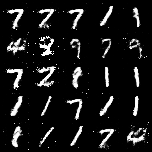

In [9]:
from IPython.display import Image

Image('92000.png')